In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
from datetime import datetime
import random
import numpy as np
from ipywidgets import interact

sys.path.append("../src")
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from real_data_desired_win_rate_reward import ProbabilityModel, BetaBernoulli, BiddingStrategy

In [3]:
cls = BetaBernoulli(1, 1000)  # Defining an instance of this BetaBernoulli with 1 win, 1000 loses as our prior
df = pd.read_csv("../data/data.csv")
df = df.query("placementType == 'banner'")
max_data_point = 1  # max value of bins
n_bins=10
desired_win_rate=0.01

In [4]:
format = "%m/%d/%Y, %H:%M:%S"
print("Start:", datetime.now().strftime(format))
biddingStrategy = BiddingStrategy(n_bins=n_bins, max_bid=max_data_point, priors=[1]*n_bins,
classifier=cls, desired_win_rate=desired_win_rate)
regret_arr, mean_regret = biddingStrategy.simulate_by_real_dataset(df.head(2000), 0.99)
print("Regret:", mean_regret)
# print(regret_arr)

Start: 05/18/2021, 14:28:28
Regret: 0.4601950900163375


Text(0.5, 1.0, 'regret over time')

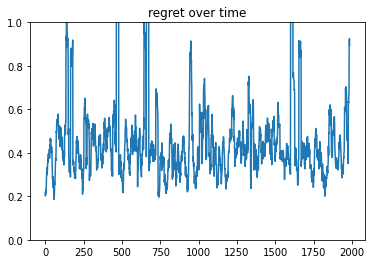

In [5]:
X = regret_arr
w=15
X  =np.convolve(X, np.ones(w), 'valid') / w
plt.plot(X)
plt.ylim((0,1))
plt.title("regret over time")

bid is: 0.42879245799375076
auction bid is: 0.47656242195843


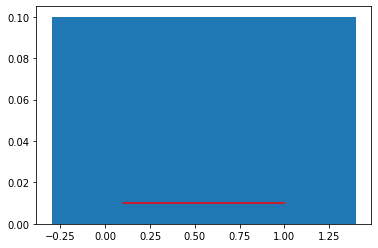

bid is: 0.4194686360277967
auction bid is: 0.4252103036522482


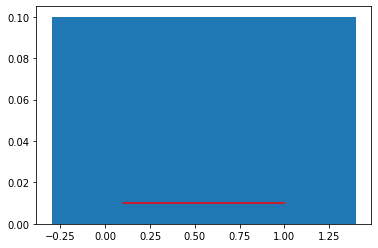

bid is: 0.5589666526417061
auction bid is: 0.30550783344147253


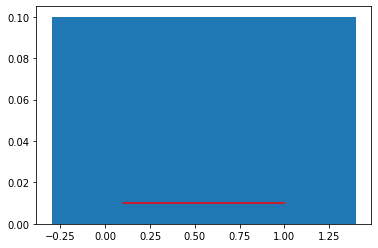

bid is: 0.8205801878700888
auction bid is: 0.38047517212524123


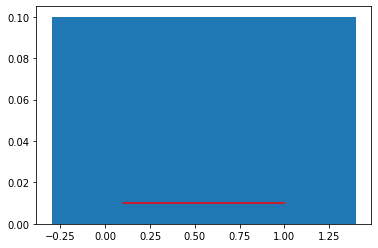

bid is: 0.5764722012014916
auction bid is: 0.36699667967958316


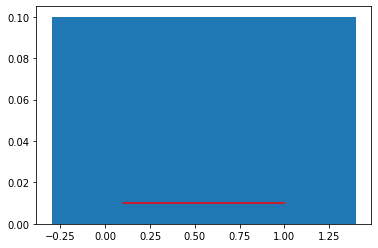

bid is: 0.8010618881693061
auction bid is: 0.3982522080179308


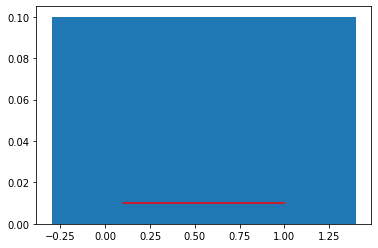

bid is: 0.6369134548177298
auction bid is: 0.33993115413062086


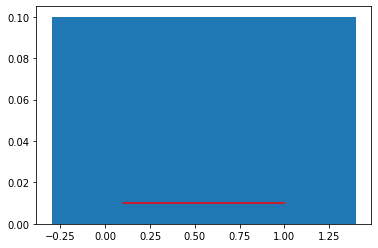

bid is: 0.40789390141660176
auction bid is: 0.4986900667312863


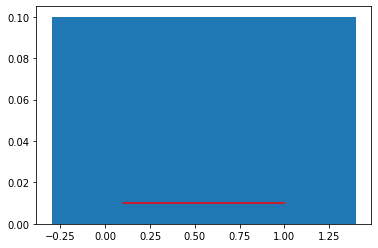

bid is: 0.36297888362202646
auction bid is: 0.45033841999567736


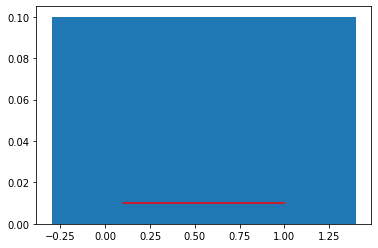

bid is: 0.1688126118199601
auction bid is: 0.3338953243352574


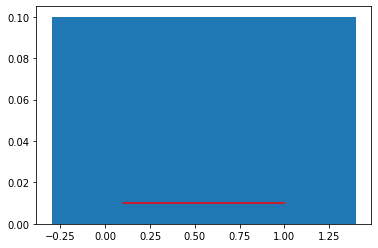

bid is: 0.6410476914685588
auction bid is: 0.3353265305446472


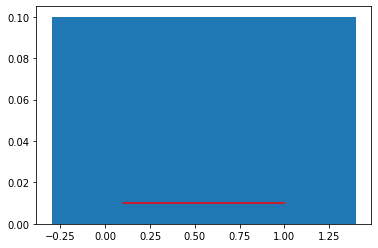

bid is: 0.05228485922875836
auction bid is: 0.36258416977186136


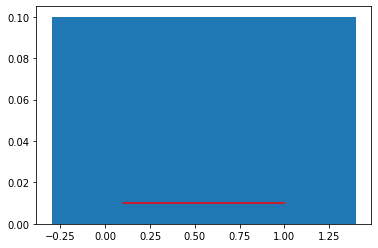

bid is: 0.02741473082891277
auction bid is: 0.40971399567448596


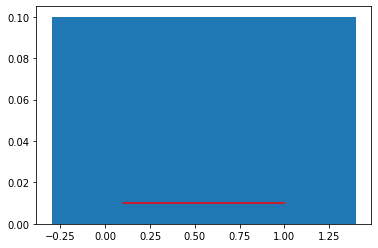

bid is: 0.36768595386198555
auction bid is: 0.37547935248167924


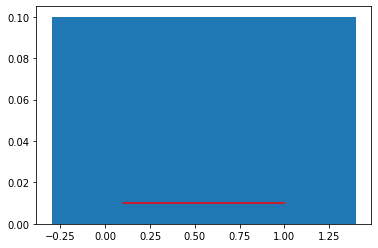

bid is: 0.31191188772996514
auction bid is: 0.4272360430096691


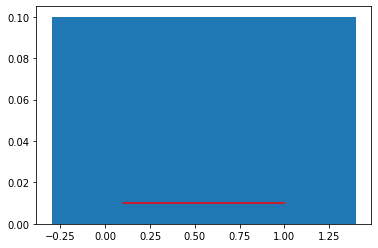

bid is: 0.012079395178831942
auction bid is: 0.4222372091189603


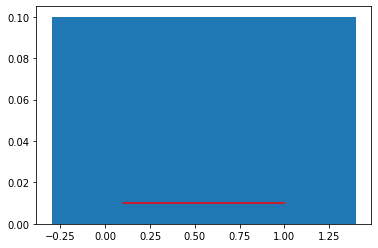

bid is: 0.17472596111352856
auction bid is: 0.46371783358233515


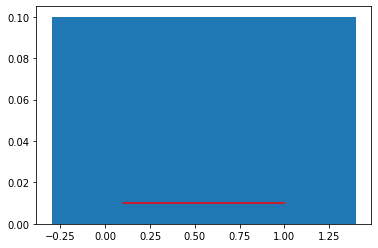

bid is: 0.7615906481035826
auction bid is: 0.37792968844531283


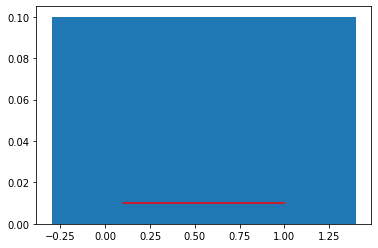

bid is: 0.9499148407343062
auction bid is: 0.378037713345705


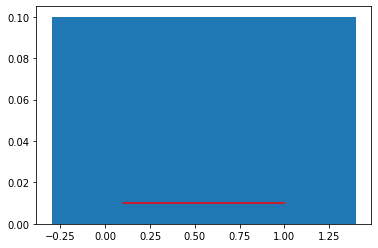

bid is: 0.4089551153656219
auction bid is: 0.41222082496604845


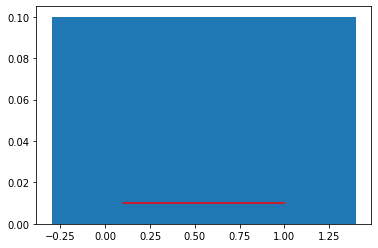

bid is: 0.8897531687189215
auction bid is: 0.48612564628292787


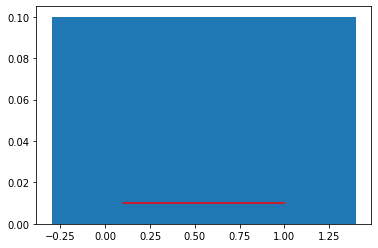

bid is: 0.03665941602092382
auction bid is: 0.3900175961828428


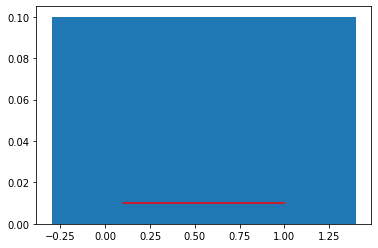

bid is: 0.2041886685261325
auction bid is: 0.48622915088813023


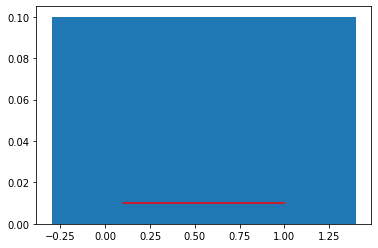

bid is: 0.3919328364918271
auction bid is: 0.30645070768315685


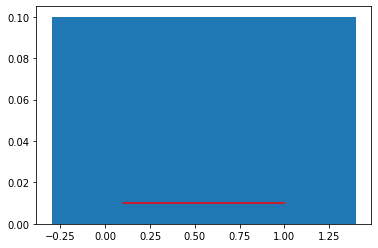

bid is: 0.43915700463171214
auction bid is: 0.46034754364180547


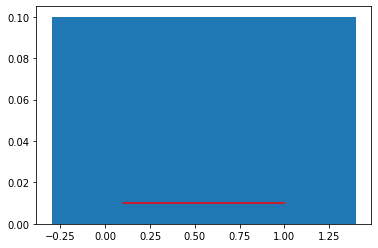

bid is: 0.2179461367368315
auction bid is: 0.4194300084596425


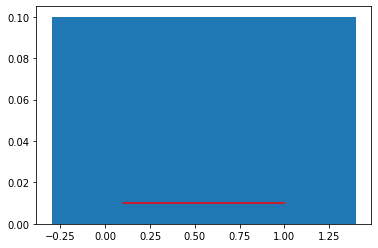

bid is: 0.8391338972386734
auction bid is: 0.4240721742312245


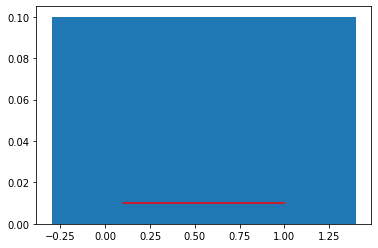

bid is: 0.6380006008764438
auction bid is: 0.3722051264263023


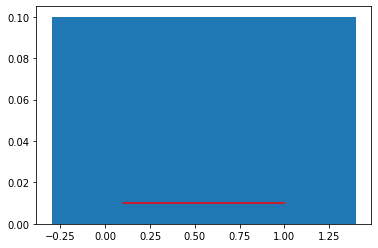

bid is: 0.7927615193003934
auction bid is: 0.41420977273999005


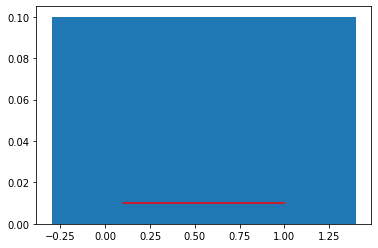

bid is: 0.8305856338639072
auction bid is: 0.38259863316627984


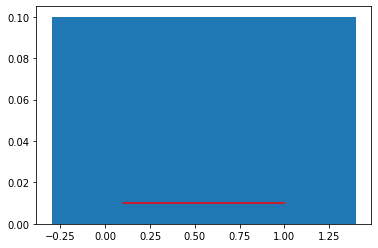

bid is: 0.6564800612990798
auction bid is: 0.3296972395028417


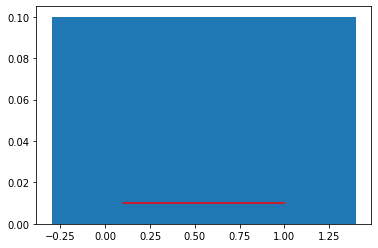

bid is: 0.3150683419202235
auction bid is: 0.49622229060075396


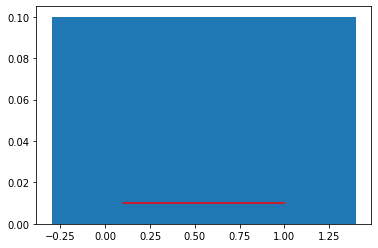

bid is: 0.572864611552289
auction bid is: 0.30001413567221463


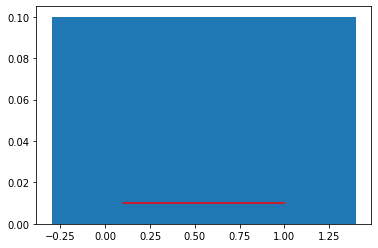

bid is: 0.9813295529772851
auction bid is: 0.4286120094658929


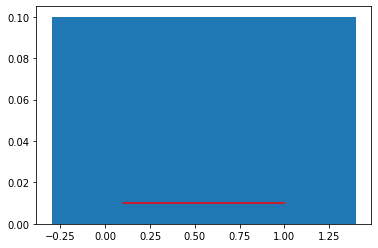

bid is: 0.18973189343428054
auction bid is: 0.39366778978456474


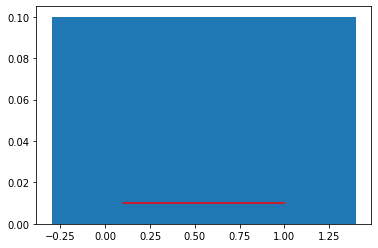

bid is: 0.8977892365072214
auction bid is: 0.4693642773884873


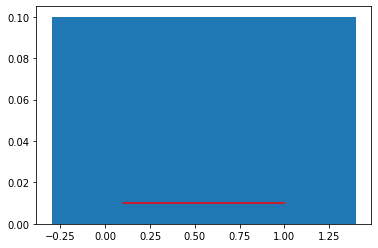

bid is: 0.3436271049298333
auction bid is: 0.40972254439760575


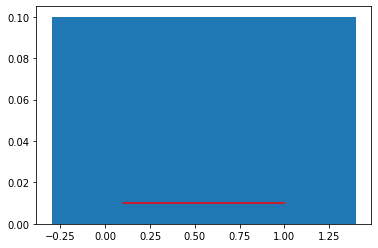

bid is: 0.9411347081669359
auction bid is: 0.439921795599314


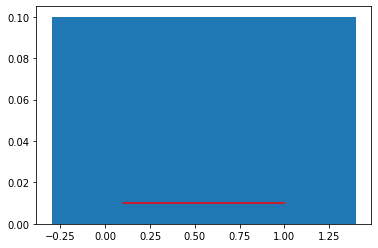

bid is: 0.4609151867657506
auction bid is: 0.4044283653227142


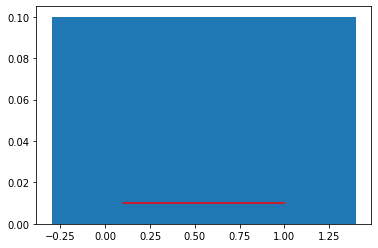

bid is: 0.7221541825721478
auction bid is: 0.4677367920525728


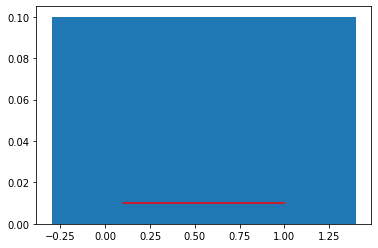

bid is: 0.7345888602693472
auction bid is: 0.32793480628261734


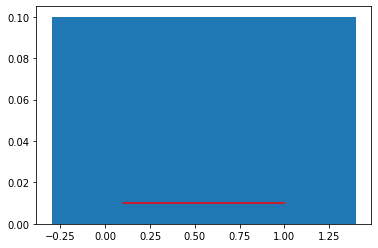

bid is: 0.19300310702602996
auction bid is: 0.3256541874354216


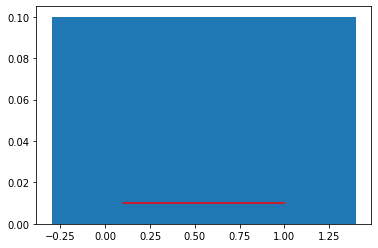

bid is: 0.6029720796823596
auction bid is: 0.40739565041832715


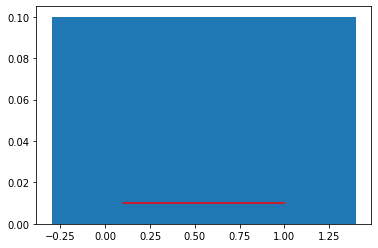

bid is: 0.5554337379206158
auction bid is: 0.44783715922154976


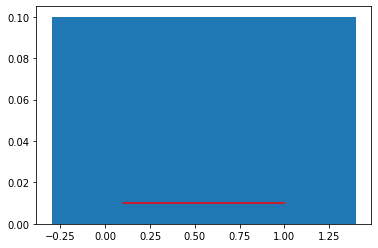

bid is: 0.6576108012945749
auction bid is: 0.38061053864242156


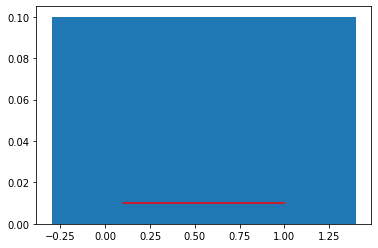

bid is: 0.29428367264447475
auction bid is: 0.4421449250748809


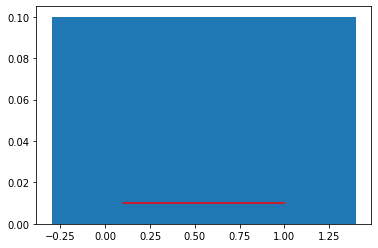

bid is: 0.5478630675447813
auction bid is: 0.45611597524849984


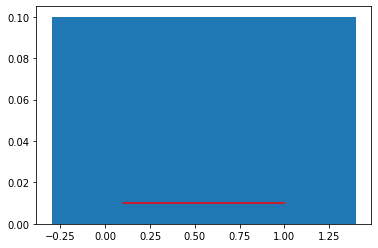

bid is: 0.841759925820127
auction bid is: 0.31595191311072657


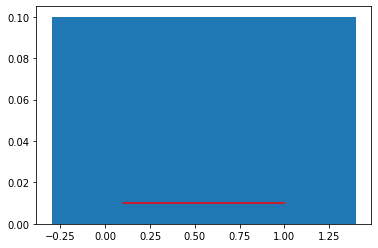

bid is: 0.1187496641440261
auction bid is: 0.39599013187827203


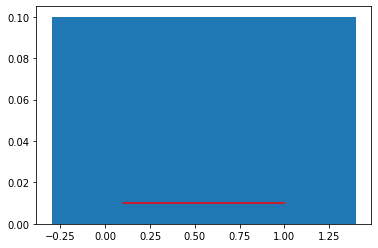

bid is: 0.6578917533778851
auction bid is: 0.4859467236120471


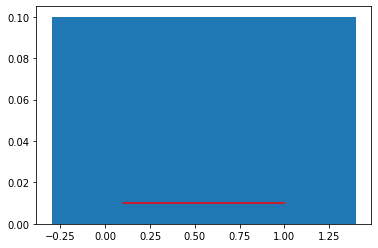

bid is: 0.09089098139296192
auction bid is: 0.34562431860817744


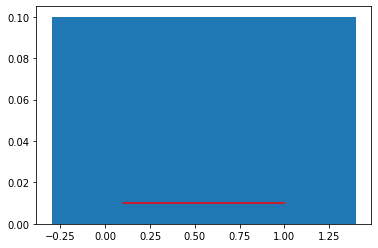

bid is: 0.15570417290138772
auction bid is: 0.3421794396562545


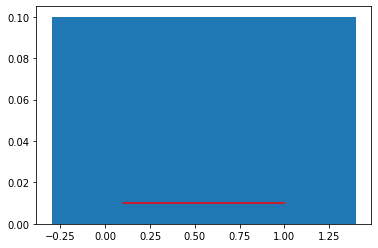

bid is: 0.7886774651133696
auction bid is: 0.3891273997226489


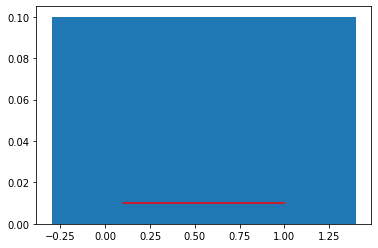

bid is: 0.19517397679824355
auction bid is: 0.43801215738828164


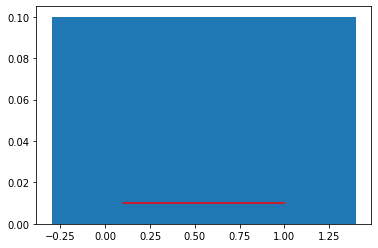

bid is: 0.5628608457239783
auction bid is: 0.47292022375077536


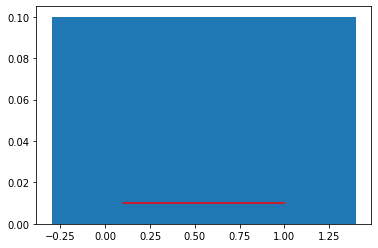

bid is: 0.31299038107577026
auction bid is: 0.349741882259595


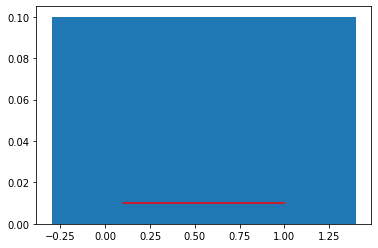

bid is: 0.08962331038123472
auction bid is: 0.44502237711394055


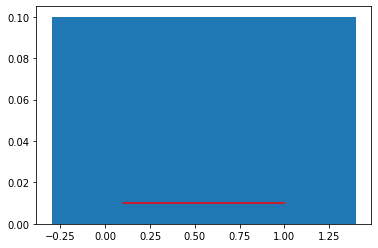

bid is: 0.7772407558736991
auction bid is: 0.35855679464737694


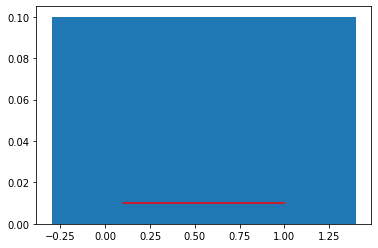

bid is: 0.9260253523070077
auction bid is: 0.48829025897151346


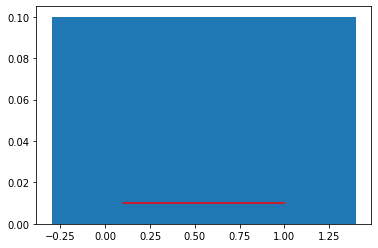

bid is: 0.03962305940847233
auction bid is: 0.44770826021568166


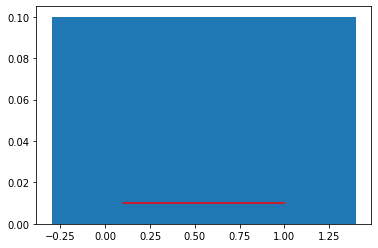

bid is: 0.23571990543603238
auction bid is: 0.40952550076952765


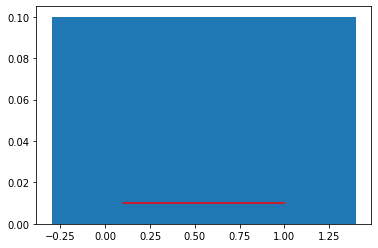

bid is: 0.9487202551934572
auction bid is: 0.3698493936004989


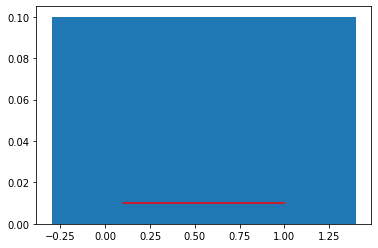

bid is: 0.23953389855199048
auction bid is: 0.343130447488201


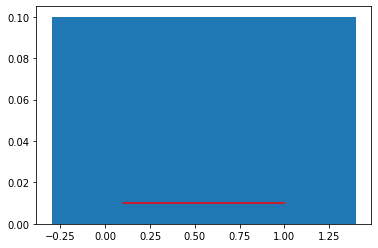

bid is: 0.70077614072581
auction bid is: 0.44538939666107136


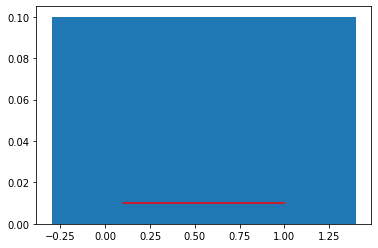

bid is: 0.2734150170262236
auction bid is: 0.3791954353982506


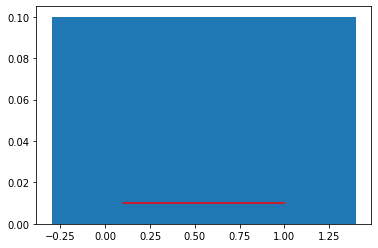

bid is: 0.038506403233963926
auction bid is: 0.49862557229947496


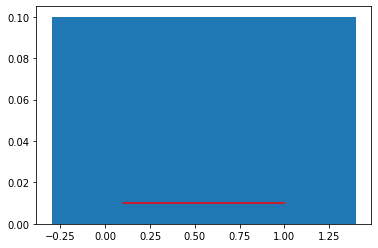

bid is: 0.17076846004297963
auction bid is: 0.4832081452465068


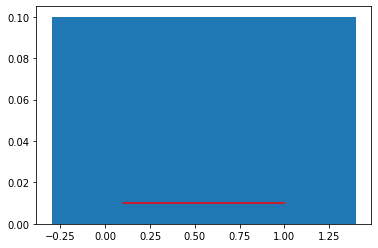

bid is: 0.2474624257209994
auction bid is: 0.39330108351870197


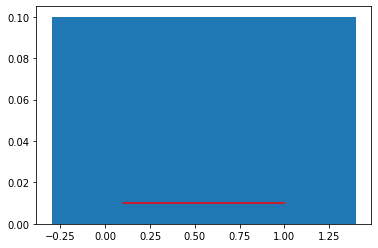

bid is: 0.7258738776069322
auction bid is: 0.3529691839384505


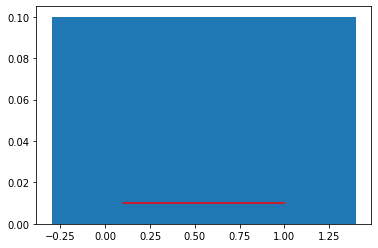

bid is: 0.0024952898130596868
auction bid is: 0.3123655106244631


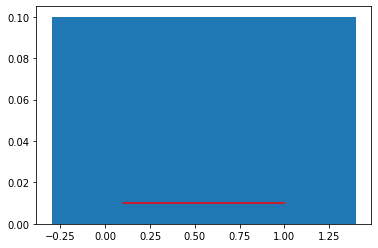

bid is: 0.2217913406726928
auction bid is: 0.33468857164257265


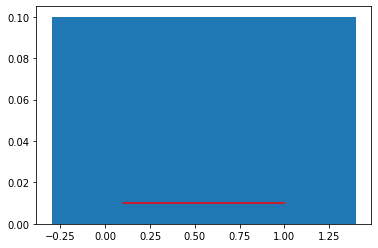

bid is: 0.7818161949148019
auction bid is: 0.45628361872535794


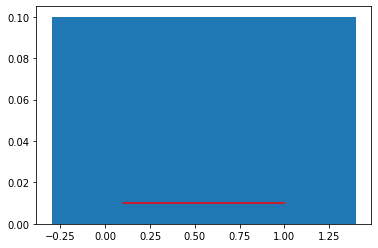

bid is: 0.03838812499639577
auction bid is: 0.32063431933455994


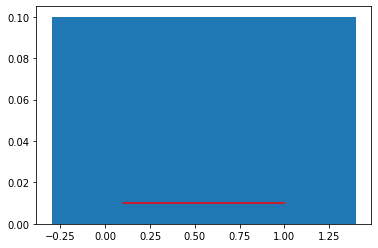

bid is: 0.28448890458684617
auction bid is: 0.46259168742991663


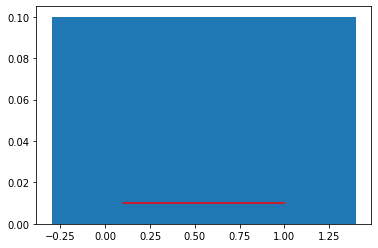

bid is: 0.21322862909241536
auction bid is: 0.36374089135722243


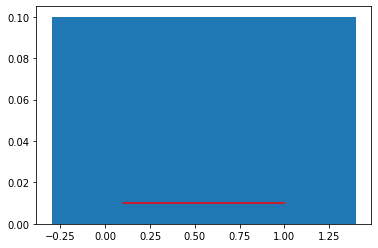

bid is: 0.08822203078297264
auction bid is: 0.34651514942236533


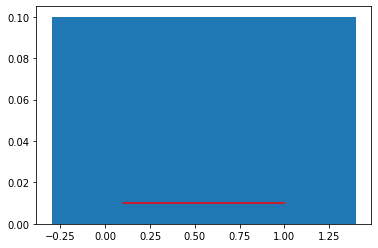

bid is: 0.8074569434326853
auction bid is: 0.35038207563366214


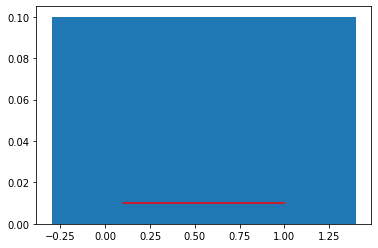

bid is: 0.6514751056013535
auction bid is: 0.4497366104289025


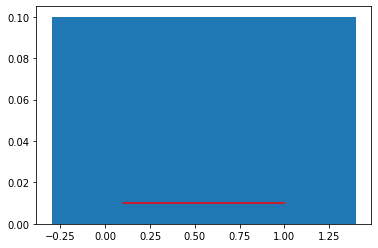

bid is: 0.3201887186598539
auction bid is: 0.33137773824231764


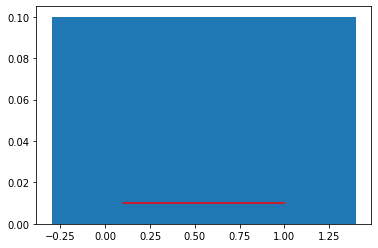

bid is: 0.47993441292655803
auction bid is: 0.37348260041912384


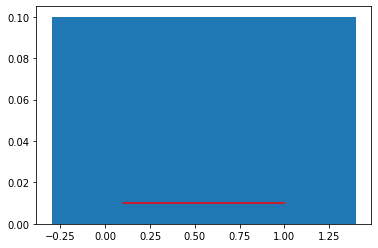

bid is: 0.14758939336855714
auction bid is: 0.43507087842535547


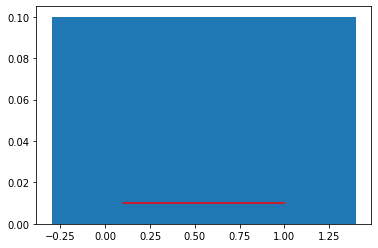

bid is: 0.3020914652461578
auction bid is: 0.4504311518543642


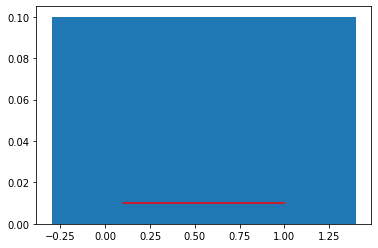

bid is: 0.48135059163998906
auction bid is: 0.3541911619613485


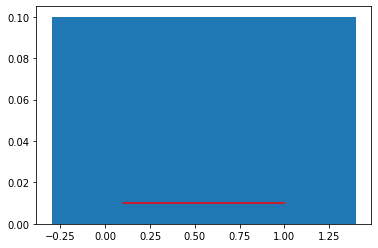

bid is: 0.3219461528550397
auction bid is: 0.31888555922079853


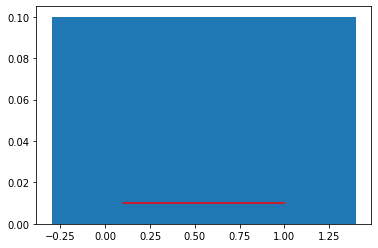

bid is: 0.6127343667203354
auction bid is: 0.35288752617349833


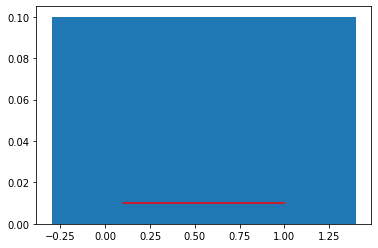

bid is: 0.2031917525227438
auction bid is: 0.4683412812630727


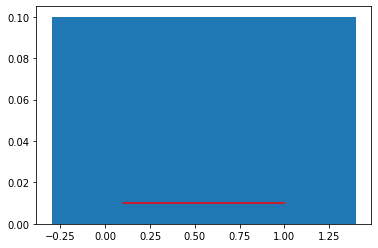

bid is: 0.12279664992280825
auction bid is: 0.34648237361215695


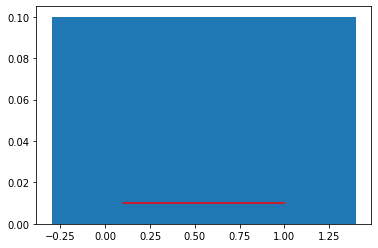

bid is: 0.7664076231702178
auction bid is: 0.446931490043331


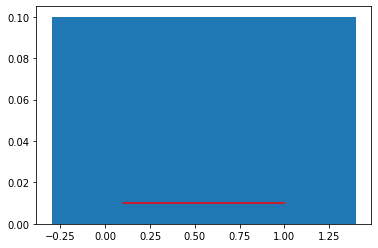

bid is: 0.49630202594924244
auction bid is: 0.3031110709688937


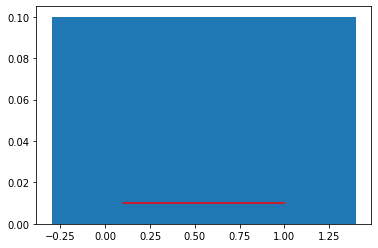

bid is: 0.9443470324391705
auction bid is: 0.36664042676780884


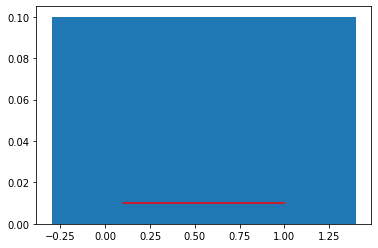

bid is: 0.3713406094472035
auction bid is: 0.46602516263646615


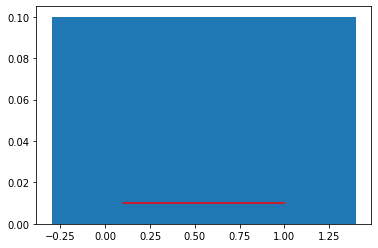

bid is: 0.4421798253501993
auction bid is: 0.47960209168935236


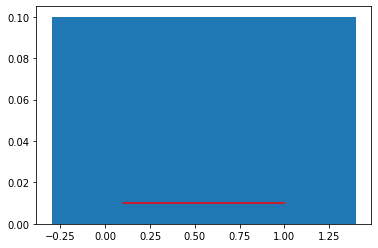

bid is: 0.11400025804640479
auction bid is: 0.4602493271262036


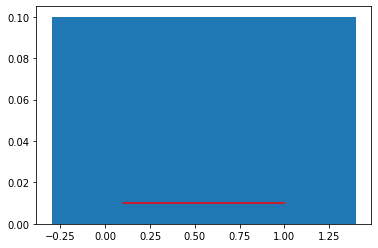

bid is: 0.583115671577086
auction bid is: 0.3451535096137875


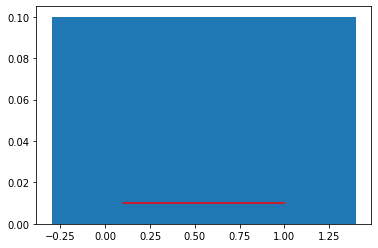

bid is: 0.11017728945735838
auction bid is: 0.3134421985176844


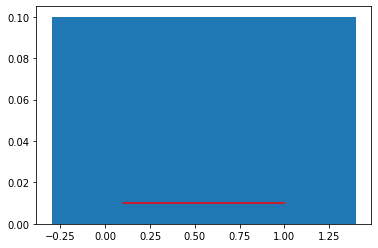

bid is: 0.2009984457775975
auction bid is: 0.4739809814404674


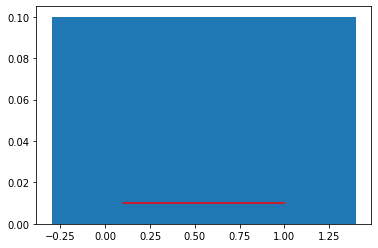

bid is: 0.7894718179878354
auction bid is: 0.4508453436931692


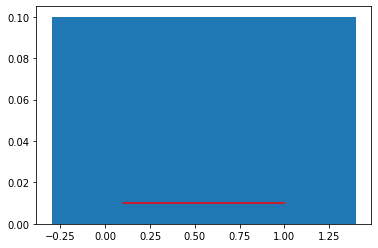

bid is: 0.2599996841127509
auction bid is: 0.3763257372990785


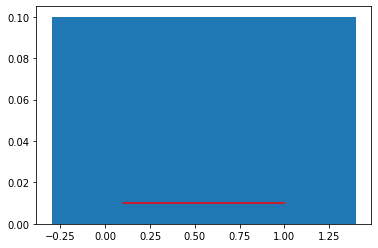

bid is: 0.30889878226137557
auction bid is: 0.4037918269705149


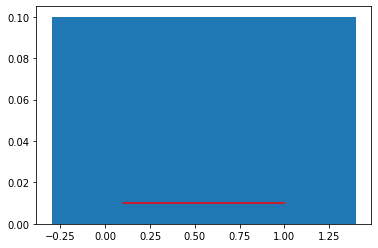

bid is: 0.24937617735263762
auction bid is: 0.461913554271683


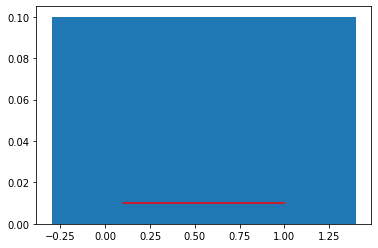

0.2490459797136504


In [6]:
reward_arr = []
bids_arr = []
win_lose_arr = []
probs_arr = []
params_arr = []
regret = 0
n_trials = 100

T_arr, F_arr = [], []

for i in range(0, n_trials):
    # b = biddingStrategy.bid([i]) # [i] is context, not used for now
    b = random.random()
    print("bid is:", b)
    normalized_prbs_arr = list(biddingStrategy.parameters().values())
    normalized_prbs_arr = biddingStrategy.normalize_probs(normalized_prbs_arr)
    params_arr.append(normalized_prbs_arr)
    
    auction_bid = 0.4 + (random.random() - 0.5) * 2 * 0.1 # generating some bid for the auction
    print("auction bid is:", auction_bid)
    
    bids_arr.append(b)
    win = b > auction_bid
    win_lose_arr.append(win)
    regret += np.abs(b - auction_bid)
    
    biddingStrategy.discount(0.99)
    
    r = biddingStrategy.reward(bid_price=b, won=win, context=[i])
    probs_arr.append(biddingStrategy.probabilities)
    reward_arr.append(r)
    
    # plot
    plt.bar(biddingStrategy.bid_model.keys(),params_arr[i])
    plt.plot(biddingStrategy.bid_model.keys(), np.ones(n_bins)*desired_win_rate, c='red')
    plt.show()
    

print(regret / n_trials)